# Project 4: West Nile Virus Prediction
## Predict West Nile virus in mosquitos across the city of Chicago


----

In [1]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.metrics import f1_score, fbeta_score


# sklearn MODELLING imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# xgboost MODELLING imports
from xgboost import XGBClassifier

# imblearn imports
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC

# misc. imports
from sklearn.decomposition import PCA


%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

### Function for printing scores

In [2]:
def print_scores(model, X_train, X_test, y_train, y_test, y_pred):
    print(classification_report(y_train, model.predict(X_train)))
    print(classification_report(y_test,y_pred))
    cm = pd.crosstab(y_test,y_pred,rownames =['Actual'], colnames =['Predicted'])
    print(cm)
    print("recall test: ", recall_score(y_test,y_pred))
    print("AUC train: ", roc_auc_score(y_train, model.predict(X_train)))
    print("AUC test: ", roc_auc_score(y_test,y_pred))
    print("f2 test: ", fbeta_score(y_test,y_pred, beta=2))
    print('accuracy: ', accuracy_score(y_test,y_pred))

# 3. Modeling
- due to imbalanced data, we use:
    - Recall (TPR): 
        - Out of total **ACTUAL** positives, how many were **PREDICTED** correctly
        - $$ Recall = TP / (TP+FN) $$
        - When False Negative is much more important, use Recall
            - e.g. cancer prediction
    - Precision (Positive Prediction value):
        - Out of total **PREDICTED** positives, how many were **ACTUAL** positives
        - $$ Precision = TP / (TP+FP) $$
        - When False Positive is much more important, use Precision
            - e.g. Spam detection
        
  - F-Beta (F1) Score:
    - $\beta$ = 1 ; when FP and FN are both equally important
    - 0 < $\beta$ <1 ; when FP more important >>> FN
    - $\beta$ > 1 ; when FN more important >>> FP
    - For our case, FN more important, so perhaps we need to use F($\beta$=2)

  - ROC - AUC Curve: 
    - When we want to vary the **probability threshold value**
    - depend on whether we want to focus on FPR or TPR or both 

- For our case of Wnv, FN is much more important as we do not want to miss out on any positive Westnilevirus as it can have detrimental effects.
- Hence, we use AUC, F1, Recall as metrics

In [3]:
# importing cleaned data from part 1
combined_clean = pd.read_csv('../data/combined_clean.csv')

In [4]:
# We remove the following columns based on qualitative assessment and due to correlation with other columns
to_drop = ['Date', 'Latitude','Longitude', 'DistFromS1','DistFromS2','Station',
'Trap', 'Year','DayOfWeek']

combined_clean = combined_clean.drop(columns=to_drop)
combined_clean = combined_clean.astype({
    'WnvPresent':object,
    'Month':object,
    'Week':object,
    'Species': object
})

combined_clean_split = pd.get_dummies(combined_clean, columns=['Species','Month','Week'], drop_first=True)

# we get rid of outliers based on NumMosquitos > (mean + 3 * std)
combined_clean_split = combined_clean_split[combined_clean_split['NumMosquitos']<241]

# Using PCA for further Feature Seleciton

In [5]:
pca = PCA(n_components=5)

X = combined_clean_split.drop(columns='WnvPresent')
y = combined_clean_split['WnvPresent'].astype(int)

X_pca = pca.fit_transform(X)
pca.explained_variance_ratio_.sum()
variable_names = X.columns
print(pca.explained_variance_ratio_)
print("Top 3 Principal Components contribute to :", sum(pca.explained_variance_ratio_[0:3]))
comps = pd.DataFrame(pca.components_, columns=variable_names)
comps

[0.85674581 0.06767481 0.04189044 0.0128245  0.01055785]
Top 3 Principal Components contribute to : 0.966311064359431


,NumMosquitos,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Trange,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Month_6,Month_7,Month_8,Month_9,Month_10,Week_23,Week_24,Week_25,Week_26,Week_27,Week_28,Week_29,Week_30,Week_31,Week_32,Week_33,Week_34,Week_35,Week_36,Week_37,Week_38,Week_39,Week_40,Week_41
0,-0.021720,-0.020071,-0.024319,-0.022220,-0.017151,-0.017698,0.008778,-0.013442,0.575266,-0.816185,-0.000578,0.000559,0.000585,-0.003852,0.001844,-0.003309,0.004249,0.001125,0.000285,-0.001448,-0.000033,0.000013,0.000057,-0.001950,-0.002599,-0.000032,0.003889,0.000793,-0.000465,-0.000415,-0.000444,-0.000612,-0.000124,-0.001134,-0.000581,-0.000610,-0.000728,-0.000360,0.000122,0.000531,0.000344,0.000429,0.000827,0.001394,0.001132,0.000729,0.000064
1,0.987507,0.065867,0.059310,0.062516,0.059647,0.056279,-0.016670,0.045846,0.061384,0.008550,0.000350,-0.000190,-0.000148,-0.001756,0.007342,0.000080,0.006557,0.000347,0.002117,-0.001872,-0.000190,-0.000017,-0.000386,-0.001910,0.000668,0.002107,-0.000450,-0.000161,-0.001080,-0.000320,-0.000190,-0.000300,-0.000238,0.000514,0.000274,0.000118,0.000394,0.000286,0.000505,0.000560,0.000445,0.000181,-0.000120,-0.000385,-0.000228,-0.000189,0.000028
2,0.155374,-0.418646,-0.383664,-0.400704,-0.396273,-0.358910,0.106618,-0.294086,-0.269841,-0.140066,-0.002532,0.002091,0.002541,0.007411,-0.123184,-0.006323,-0.034982,-0.002665,0.000726,0.002524,-0.000076,0.000061,-0.000568,0.006646,-0.001601,-0.007814,0.000807,0.001323,0.004565,0.002132,0.000462,-0.000545,0.000539,-0.000298,-0.000414,-0.001494,-0.002064,-0.001220,0.000323,-0.003838,-0.002118,-0.001424,0.002056,0.000677,0.000700,0.001174,0.000149
3,0.001514,0.115379,0.158934,0.139832,0.148456,0.128323,-0.027598,0.112234,-0.669804,-0.493024,0.006031,-0.000037,-0.000112,0.030681,-0.441161,0.018921,-0.043556,-0.000246,-0.000954,0.001051,-0.000064,-0.000004,0.000234,0.008527,-0.005612,-0.003002,-0.002409,0.002493,0.001029,0.002407,0.001651,0.003487,-0.000140,0.000135,-0.001993,-0.001804,-0.002533,0.001403,0.008141,-0.009137,-0.003202,-0.004281,-0.006931,0.003545,0.005726,0.002459,0.000034
4,-0.013639,-0.092813,0.031467,-0.032228,0.037300,0.011253,0.013995,-0.018233,0.369550,0.260775,-0.000032,0.003208,0.003138,-0.097428,-0.864401,-0.099729,-0.124280,0.002140,-0.000562,-0.001379,-0.000020,0.000032,-0.000215,0.000938,-0.010281,0.013851,-0.000983,-0.002254,0.002288,0.002543,-0.002590,-0.001103,-0.000002,-0.003704,-0.004282,-0.001193,0.001603,0.002159,0.000026,0.004693,0.004594,0.003086,0.002675,-0.004390,-0.002877,-0.001719,-0.000535


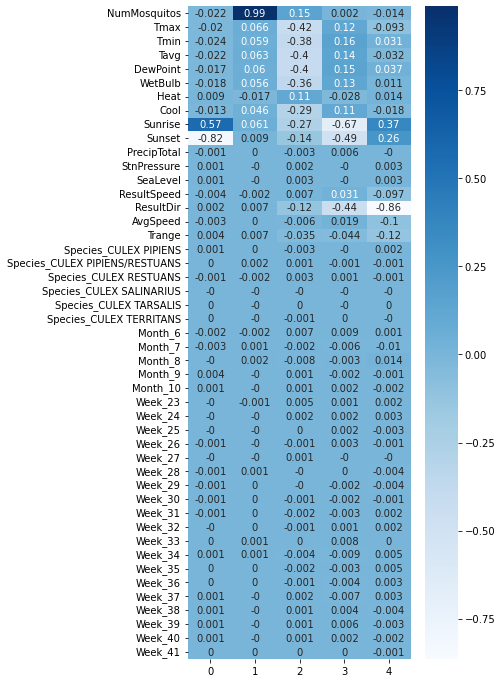

In [6]:
comps = np.round(comps,3)
plt.figure(figsize=(5,12))
sns.heatmap(comps.T, cmap="Blues", annot=True);

- Based on the above PCA analysis, the first 3 Principal Components explained 96.6% of the data set's variance, which means the 3 components hold 96.6% of the information in the data.
- By taking the first 3 components, we only lose 3.4% of the data sets info which could be the 'junk' info or noise which we want to remove.
- From the heatmap, we can observe the features that contribute most to each PC.
- Based on PCA heatmap and qualitative assessment of each feature, we further drop the following features below.

In [7]:
to_drop = ['StnPressure','SeaLevel','Cool','WetBulb','DewPoint','Tmax','Tmin']
combined_clean_split = combined_clean_split.drop(columns=to_drop)

___

# Train-Test-Split

In [8]:
# train test split
X = combined_clean_split.drop(columns='WnvPresent')
y = combined_clean_split['WnvPresent'].astype(int)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)

In [9]:
X_train.head()

,NumMosquitos,Tavg,Heat,Sunrise,Sunset,PrecipTotal,ResultSpeed,ResultDir,AvgSpeed,Trange,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Month_6,Month_7,Month_8,Month_9,Month_10,Week_23,Week_24,Week_25,Week_26,Week_27,Week_28,Week_29,Week_30,Week_31,Week_32,Week_33,Week_34,Week_35,Week_36,Week_37,Week_38,Week_39,Week_40,Week_41
5592,14,77.0,0.0,449.0,1907.0,0.00,5.2,7.0,6.0,14.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8319,8,77.0,0.0,536.0,1755.0,0.00,7.8,16.0,10.0,14.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3288,1,78.0,0.0,418.0,1931.0,0.00,6.4,4.0,8.2,17.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
592,1,77.0,0.0,440.0,1917.0,0.17,3.0,3.0,7.9,13.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1783,1,75.0,0.0,509.0,1840.0,0.24,5.8,25.0,7.1,11.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [10]:
# creating dataframe to keep track of AUC, F1, F2, Recall scores
df_scores = pd.DataFrame()
df_scores["Scores"] = ['Recall','AUC','F1','F2','TP','FN','FP','TN']
df_scores = df_scores.set_index("Scores")

___

# BASELINE MODEL (without upsampling)

In [11]:
# metric calculation based on best model
clf = LogisticRegression(random_state=42)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

clf.fit(X_train_sc, y_train)
y_pred = clf.predict(X_test_sc)

print_scores(clf, X_train_sc, X_test_sc, y_train, y_test, y_pred)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5588
           1       0.49      0.06      0.11       299

    accuracy                           0.95      5887
   macro avg       0.72      0.53      0.54      5887
weighted avg       0.93      0.95      0.93      5887

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2395
           1       0.53      0.06      0.11       128

    accuracy                           0.95      2523
   macro avg       0.74      0.53      0.54      2523
weighted avg       0.93      0.95      0.93      2523

Predicted     0  1
Actual            
0          2388  7
1           120  8
recall test:  0.0625
AUC train:  0.5284002628661992
AUC test:  0.5297886221294363
f2 test:  0.07590132827324478
accuracy:  0.9496630994847404


In [12]:
# add baseline score to df_scores
TP = pd.crosstab(y_test,y_pred)[1][1]
FN = pd.crosstab(y_test,y_pred)[0][1]
FP = pd.crosstab(y_test,y_pred)[1][0]
TN = pd.crosstab(y_test,y_pred)[0][0]


df_scores['Baseline'] = [recall_score(y_test,y_pred),roc_auc_score(y_test,y_pred), 
                                    f1_score(y_test,y_pred),fbeta_score(y_test,y_pred,beta=2),TP,FN,FP,TN]

___

# MODELLING (GridSearch with upsampling)
- we predict our model using gridsearch 
- take note, we are using imblearn's pipeline here (not sklearn's), in order to include the SMOTE, sklearn's pipeline could not fit the SMOTE

In [13]:
# creating pipeline and gridsearch hypertuning
steps = [
    ('smk', SMOTETomek(random_state=42)),
    ('ss', StandardScaler()),
    ('clf', LogisticRegression(random_state=42)),
]

# initializing pipeline steps
pipe = Pipeline(steps)

# setting gridsearch hyperparameter tuning
grid_params = [    
    {
        'clf': [LogisticRegression(random_state=42)],
        'clf__penalty': ['l1','l2'],
        'clf__C': [0.1,1],

    },
    
    {
        'clf': [AdaBoostClassifier(random_state=42)],
        'clf__n_estimators': [30,50],
        'clf__learning_rate': [1,10],
    },
    
    {
        'clf': [GradientBoostingClassifier(random_state=42)],
        'clf__learning_rate': [0.05,0.1],
        'clf__min_samples_split': [500,700],
        'clf__min_samples_leaf': [50],
        'clf__max_features': ['sqrt','log2'],
        'clf__max_depth': [5]     
    
    },
    

    {
        'clf': [SVC(random_state=42)],
        'clf__C' : [1,10]
    },

    {
        'clf': [XGBClassifier(random_state=42,verbosity=0)],
        'clf__learning_rate':[0.1],
        'clf__n_estimators': [150],
        'clf__max_depth': range(3)
    }
]


# gridsearch with AUC as metric
gridauc = GridSearchCV(pipe, grid_params, cv =10, verbose=2, n_jobs=-1, scoring='roc_auc')

### Metric scores based on Best AUC Model

In [14]:
gridauc.fit(X_train, y_train)
bestmodel_auc = gridauc.best_estimator_
# we use fit.resample as there is resampling done using SMOTE in pipeline
bestmodel_auc.fit_resample(X_train,y_train)
y_pred = bestmodel_auc.predict(X_test)

print_scores(bestmodel_auc, X_train, X_test, y_train, y_test, y_pred)
print(bestmodel_auc)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      5588
           1       0.21      0.77      0.33       299

    accuracy                           0.84      5887
   macro avg       0.60      0.81      0.62      5887
weighted avg       0.95      0.84      0.88      5887

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2395
           1       0.23      0.81      0.35       128

    accuracy                           0.85      2523
   macro avg       0.61      0.83      0.63      2523
weighted avg       0.95      0.85      0.89      2523

Predicted     0    1
Actual              
0          2038  357
1            24  104
recall test:  0.8125
AUC train:  0.8061436594901161
AUC test:  0.8317197286012527
f2 test:  0.5344295991778006
accuracy:  0.8489892984542212
Pipeline(steps=[('smk', SMOTETomek(random_state=42)), ('ss

In [15]:
# add best AUC score to df_scores
TP = pd.crosstab(y_test,y_pred)[1][1]
FN = pd.crosstab(y_test,y_pred)[0][1]
FP = pd.crosstab(y_test,y_pred)[1][0]
TN = pd.crosstab(y_test,y_pred)[0][0]

df_scores['optimized_by_AUC'] = [recall_score(y_test,y_pred),roc_auc_score(y_test,y_pred), f1_score(y_test,y_pred),fbeta_score(y_test,y_pred,beta=2), TP,FN,FP,TN]


___

# Model Evaluation
- as our dataset is severely imbalanced, we must consider score metrics other than accuracy.
- we use AUC under ROC curve as the ROC does not depend on class distribution and therefore making it useful for imbalanced dataset like ours.
- XGBoost was found to be the best model based on AUC Score.

In [16]:
print(gridauc.best_estimator_)

Pipeline(steps=[('smk', SMOTETomek(random_state=42)), ('ss', StandardScaler()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=1,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=12, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=0))])


___

# Overall scores for all models

In [17]:
df_scores = df_scores.T
df_scores = df_scores.astype({'TP':int,'FN':int,'FP':int,'TN':int})
df_scores

Scores,Recall,AUC,F1,F2,TP,FN,FP,TN
Baseline,0.0625,0.529789,0.111888,0.075901,8,120,7,2388
optimized_by_AUC,0.8125,0.831720,0.353141,0.534430,104,24,357,2038


#### List of scores for each model

In [18]:
results_df = pd.DataFrame(gridauc.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]


,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=1,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=150, n_jobs=None, num_parallel_tree=None,\n random_state=42, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=0)_0.1_1_150","{'clf': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_delta_step=None, max_depth=1, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=150, n_jobs=None, num_parallel_tree=None, random_state=42, reg_alpha=None, reg_lambda=None, scale_pos_weight=None, subsample=None, tree_method=None, validate_parameters=None, verbosity=0), 'clf__learning_rate': 0.1, 'clf__max_depth': 1, 'clf__n_estimators': 150}",1,0.872275,0.031020
"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=1,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=150, n_jobs=None, num_parallel_tree=None,\n random_state=42, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=0)_0.1_2_150","{'clf': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_delta_step=None, max_depth=1, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=150, n_jobs=None, num_parallel_tree=None, random_state=42, reg_alpha=None, reg_lambda=None, scale_pos_weight=None, subsample=None, tree_method=None, validate_parameters=None, verbosity=0), 'clf__learning_rate': 0.1, 'clf__max_depth': 2, 'clf__n_estimators': 150}",2,0.872264,0.031302
AdaBoostClassifier(random_state=42)_1_50,"{'clf': AdaBoostClassifier(random_state=42), 'clf__learning_rate': 1, 'clf__n_estimators': 50}",3,0.870184,0.034995
GradientBoostingClassifier(random_state=42)_0.05_5_sqrt_50_700,"{'clf': GradientBoostingClassifier(random_state=42), 'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 50, 'clf__min_samples_split': 700}",4,0.868791,0.032152
GradientBoostingClassifier(random_state=42)_0.05_5_sqrt_50_500,"{'clf': GradientBoostingClassifier(random_state=42), 'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 50, 'clf__min_samples_split': 500}",5,0.868513,0.033666
GradientBoostingClassifier(random_state=42)_0.05_5_log2_50_500,"{'clf': GradientBoostingClassifier(random_state=42), 'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 50, 'clf__min_samples_split': 500}",6,0.866424,0.033692
GradientBoostingClassifier(random_state=42)_0.05_5_log2_50_700,"{'clf': GradientBoostingClassifier(random_state=42), 'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 50, 'clf__min_samples_split': 700}",7,0.865996,0.035044
AdaBoostClassifier(random_state=42)_1_30,"{'clf': AdaBoostClassifier(random_state=42), 'clf__learning_rate': 1, 'clf__n_estimators': 30}",8,0.864284,0.032419
GradientBoostingClassifier(random_state=42)_0.1_5_log2_50_700,"{'clf': GradientBoostingClassifier(random_state=42), 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_s

___

# Feature extraction
- Knowing the best model is XGBoost, we extract the top features
- We also plot the ROC curve to visualize the AUC 

#### XGBoost Feature Extraction

In [19]:
X = combined_clean_split.drop(columns='WnvPresent')
y = combined_clean_split['WnvPresent'].astype(int)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)

clf = XGBClassifier(learning_rate=0.1,
                    n_estimators=150,
                    max_depth=1,
                    random_state=42)
ss = StandardScaler()
smk = SMOTETomek(random_state=42)

X_train_res, y_train_res = smk.fit_resample(X_train, y_train)

X_train_sc = ss.fit_transform(X_train_res)
X_test_sc = ss.transform(X_test)

clf.fit(X_train_sc, y_train_res)
y_pred = clf.predict(X_test_sc)
x = list(zip(X.columns, clf.feature_importances_))

print_scores(clf, X_train_sc, X_test_sc, y_train_res, y_test, y_pred)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      5505
           1       0.86      0.89      0.87      5505

    accuracy                           0.87     11010
   macro avg       0.87      0.87      0.87     11010
weighted avg       0.87      0.87      0.87     11010

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2395
           1       0.23      0.81      0.35       128

    accuracy                           0.85      2523
   macro avg       0.61      0.83      0.63      2523
weighted avg       0.95      0.85      0.89      2523

Predicted     0    1
Actual              
0          2038  357
1            24  104
recall test:  0.8125
AUC train:  0.8706630336058129
AUC test:  0.8317197286012527
f2 test:  0.5344295991778006
accuracy:  0.8489892984542212


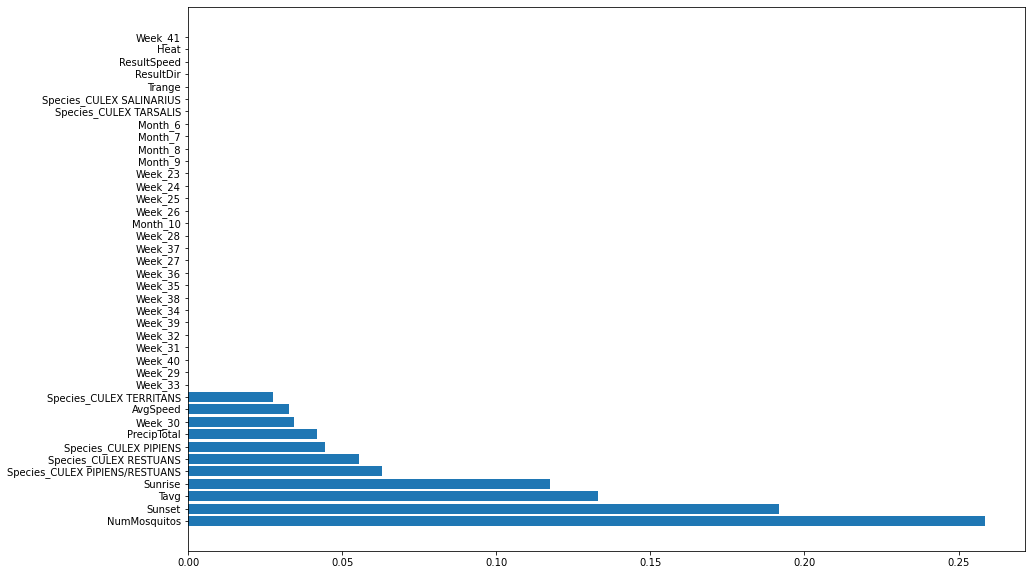

In [20]:
df_feat = pd.DataFrame(x).sort_values(by=1, ascending=False)
df_feat.columns = ['Feature', 'Feature_Importance']
plt.figure(figsize=(15,10))
plt.barh(df_feat['Feature'], df_feat['Feature_Importance']);

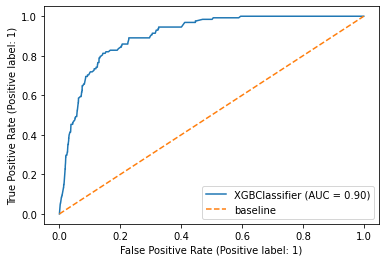

In [21]:
plot_roc_curve(clf, X_test_sc, y_test) 
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

With the charts above, we can see that the top features are mostly on:
- NumMosquitos
- Sunset
- Sunrise
- Average Temperature
- Precipitation
- Average Wind Speed

Additionally, specifically mosquitos of the species Culex Pipiens / Restuans / Territans and the Week 30 are also important to determining the probability of getting presence of Westnilevirus. 